# Compare the floe size distribution tendencies from ACCESS-OM3 output.

The floe size distribution (FSD) in CICE is an extension of the ice thickness distribution (ITD) to account for the varying perimeters of ice floes across the ice pack. The FSTD is goverened by the following equation
$$ \frac{\partial f(r,h)}{\partial t} = -\nabla \cdot (f(r,h)\mathbf{u}) + \mathcal{L}_T + \mathcal{L}_M + \mathcal{L}_W $$
where the terms on the right hand side represent advection, thermodynamics, mechanical redistribution, and wave-induced breakup.


In this notebook we compare the relative contributions of these terms on the FSD (that is integrated over thickness space) XXXXX...


**TO-DO**:
- fs

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file = f"/scratch/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-analysis-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-analysis-figs/


In [15]:
from intake import cat
from xarray import DataTree, map_over_datasets
from distributed import Client
import glob
import xarray as xr
import cf_xarray
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re
import os
import time
import intake


# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import matplotlib.path as mpath

In [5]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46761 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46761/status,
Dashboard: /proxy/46761/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45065,Workers: 0
Dashboard: /proxy/46761/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42815,Total threads: 1
Dashboard: /proxy/42829/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35461,


In [6]:
print(client.dashboard_link)

/proxy/46761/status


### Open the intake-esm datastore

In [7]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


In [9]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [10]:
datastore_filtered = datastore.search(realm="seaIce", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
ANGLE,angle grid makes with latitude line on U grid,,,radians
ANGLET,angle grid makes with latitude line on T grid,,,radians
NCAT,category maximum thickness,,,m
Tair_m,air temperature,,time: mean,C
Tsfc_m,snow/ice surface temperature,,time: mean,C
...,...,...,...,...
vatm_m,atm velocity (y),,time: mean,m/s
vicen_m,"ice volume, categories",,time: mean,m
vort_m,strain rate (vorticity),,time: mean,%/day


### Read in FSD source terms

In [11]:
ds = datastore.search(variable=["NFSD", "aice_m", "hi_m", "fsdrad_m", "afsd_m", "dafsd_newi_m", "dafsd_latg_m", "dafsd_latm_m", "dafsd_wave_m", "dafsd_weld_m", "afsdn_m"], 
    frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute() # TODO why do we need file_id for my runs??
coords = coords.fillna(0.0)
coords = coords.rename({'geolat': 'lat', 'geolon': 'lon'})
ds_grid = datastore.search(variable=["tarea", "HTE", "NFSD"], frequency="fx", realm="seaIce").to_dask().compute()
ds = ds.assign_coords(ds_grid)
ds = ds.assign_coords(coords)
ds = ds.rename({'xh':'ni', 'yh':'nj'})
ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 4GB
Dimensions:       (time: 37, nf: 12, nj: 300, ni: 360, nc: 5)
Coordinates: (12/17)
  * time          (time) object 296B 1900-01-16 12:00:00 ... 1903-01-16 12:00:00
    NCAT          (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    TLON          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    TLAT          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULON          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ULAT          (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    ...            ...
    tarea         (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
    HTE           (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan
  * ni            (ni) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * nj            (nj) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    lon           (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.96 79.97 79.99
    lat           (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.04 65.63 65.21
Dimensions without coordinates: nf, nc
Data variables:
    dafsd_latg_m  (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    afsdn_m       (time, nc, nf, nj, ni) float64 2GB dask.array<chunksize=(1, 3, 6, 300, 360), meta=np.ndarray>
    dafsd_weld_m  (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    fsdrad_m      (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    dafsd_wave_m  (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    dafsd_latm_m  (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    aice_m        (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    dafsd_newi_m  (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    afsd_m        (time, nf, nj, ni) float64 384MB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    hi_m          (time, nj, ni) float64 32MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

### Maps of FSDRAD

In [18]:
def get_proj(hemisphere):
    if hemisphere.lower().startswith('s'):
        projection = ccrs.SouthPolarStereo(central_longitude=0)
        extent = [-180, 180, -90, -40]
    elif hemisphere.lower().startswith('n'):
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
        )
        extent = [0, 360, 40, 90]
    else:
        raise ValueError("hemisphere must be 'north' or 'south'")
    return projection, extent



def map_figure(hemisphere, number_panels=2):

    projection, extent = get_proj(hemisphere)

    # Make figure
    fig, axes = plt.subplots(
        ncols=number_panels,
        subplot_kw={'projection': projection},
        figsize=(4 * number_panels, 4),
        gridspec_kw={'wspace': 0.25, 'hspace': 0.15}
    )

    for i, ax in enumerate(axes):
        ax.set_extent(extent, crs=ccrs.PlateCarree())

        land_50m = cft.NaturalEarthFeature(
            'physical', 'land', '50m',
            edgecolor='none',
            linewidth=0.5
        )
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)

        # Circular boundary
        theta = np.linspace(0, 2*np.pi, 100)
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * 0.5 + np.array([0.5, 0.5]))
        ax.set_boundary(circle, transform=ax.transAxes)


    return fig, axes

def get_cice_binwidths(NFSD):
    """
    Return the bin widths used in CICE.

    Args:
        NFSD (ndarray): Floe bin centres [m]

    Returns:
        BinWidths (ndarray): Binwidths [m]
        BinLeft (ndarray): Binwidths [m]
        BinRight (ndarray): Binwidths [m]
    """
    min_floe = 6.65000000e-02;
    # Define arrays
    fsd_lims = np.zeros(len(NFSD)+1)
    floe_rad_c = np.zeros(len(NFSD))
    floe_rad_l = np.zeros(len(NFSD))
    floe_rad_h = np.zeros(len(NFSD))
    
    fsd_lims[1] = min_floe;
    for i in range(len(NFSD)):
        fsd_lims[i+1] = 2*NFSD[i] - fsd_lims[i]
        floe_rad_c[i] = NFSD[i]
    
    
    floe_rad_l = fsd_lims[0:-1]
    floe_rad_h = fsd_lims[1:]
    floe_binwidth = floe_rad_h - floe_rad_l
    
    floeshape = 0.66;
    floe_area_l = 4*floeshape*floe_rad_l**2
    floe_area_c = 4*floeshape*floe_rad_c**2
    floe_area_h = 4*floeshape*floe_rad_h**2
    
    BinWidths = floe_rad_h - floe_rad_l
    BinRight = floe_rad_h
    BinLeft = floe_rad_l

    return BinWidths, BinLeft, BinRight

def get_representative_floe_size(NFSD_in, afsd_in, aice_in):
    floe_binwidth = NFSD_in.copy()
    floe_binwidth.values, _, _, _, _, _ = ciceBinWidths(NFSD_in)
    afsd_in = afsd_in * floe_binwidth
    Nf = len(NFSD_in)
    rep_floe_size = (afsd_in*NFSD /aice_in).sum(dim='nf') 
    return rep_floe_size

NFSD = ds.NFSD    
binwidths, bin_edge_left, bin_edge_right = get_cice_binwidths(NFSD)

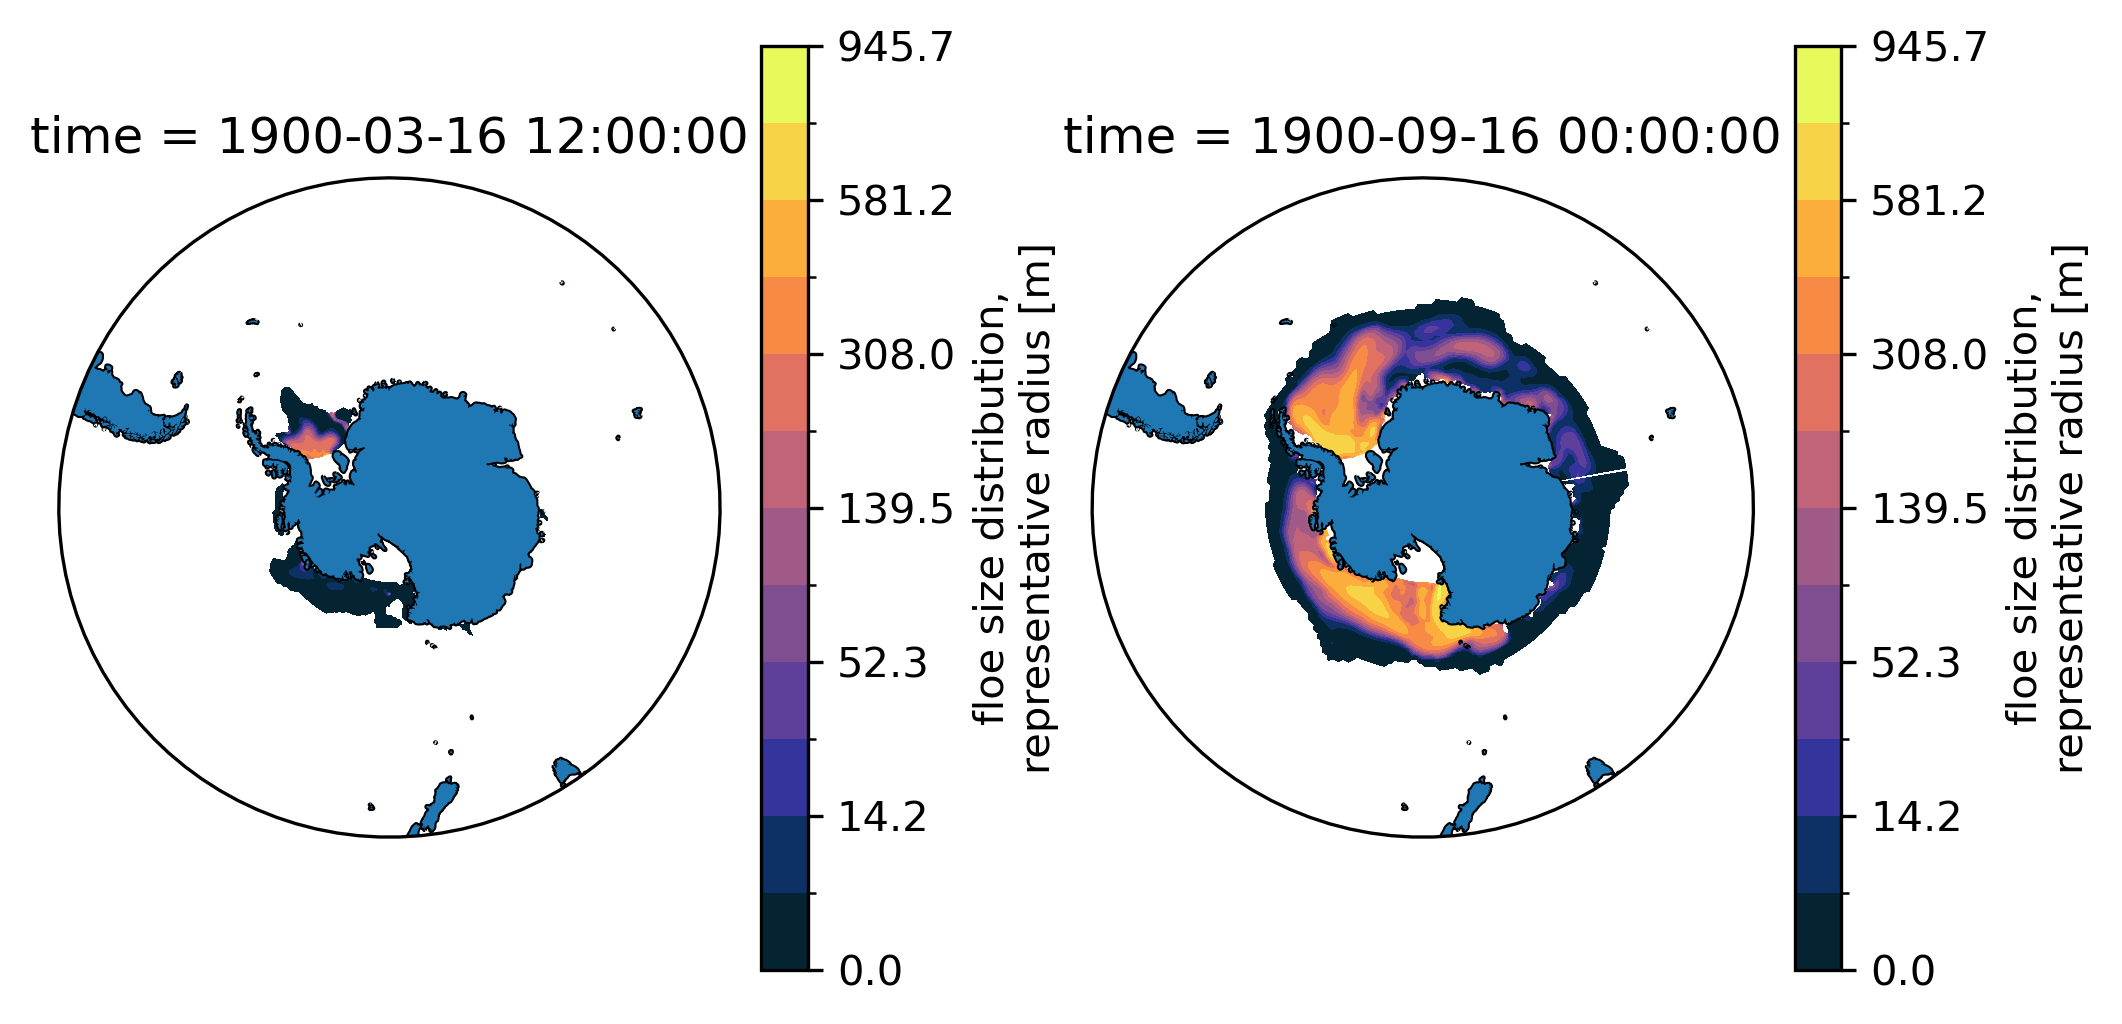

In [19]:
levels = np.concatenate([BinLeft, [BinRight[-1]]])
hemisphere = "south"

fig, axes = map_figure(hemisphere)

ds_plot = ds.where(ds['aice_m']>0.15)
ds_plot['fsdrad_m'].isel(time=2).plot.contourf(
        ax=axes[0],
        x="lon",
        y="lat",
        levels=levels,  
        cmap=cmo.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=True
    )

ds_plot['fsdrad_m'].isel(time=8).plot.contourf(
        ax=axes[1],
        x="lon",
        y="lat",
        levels=levels,  
        cmap=cmo.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=True
    )

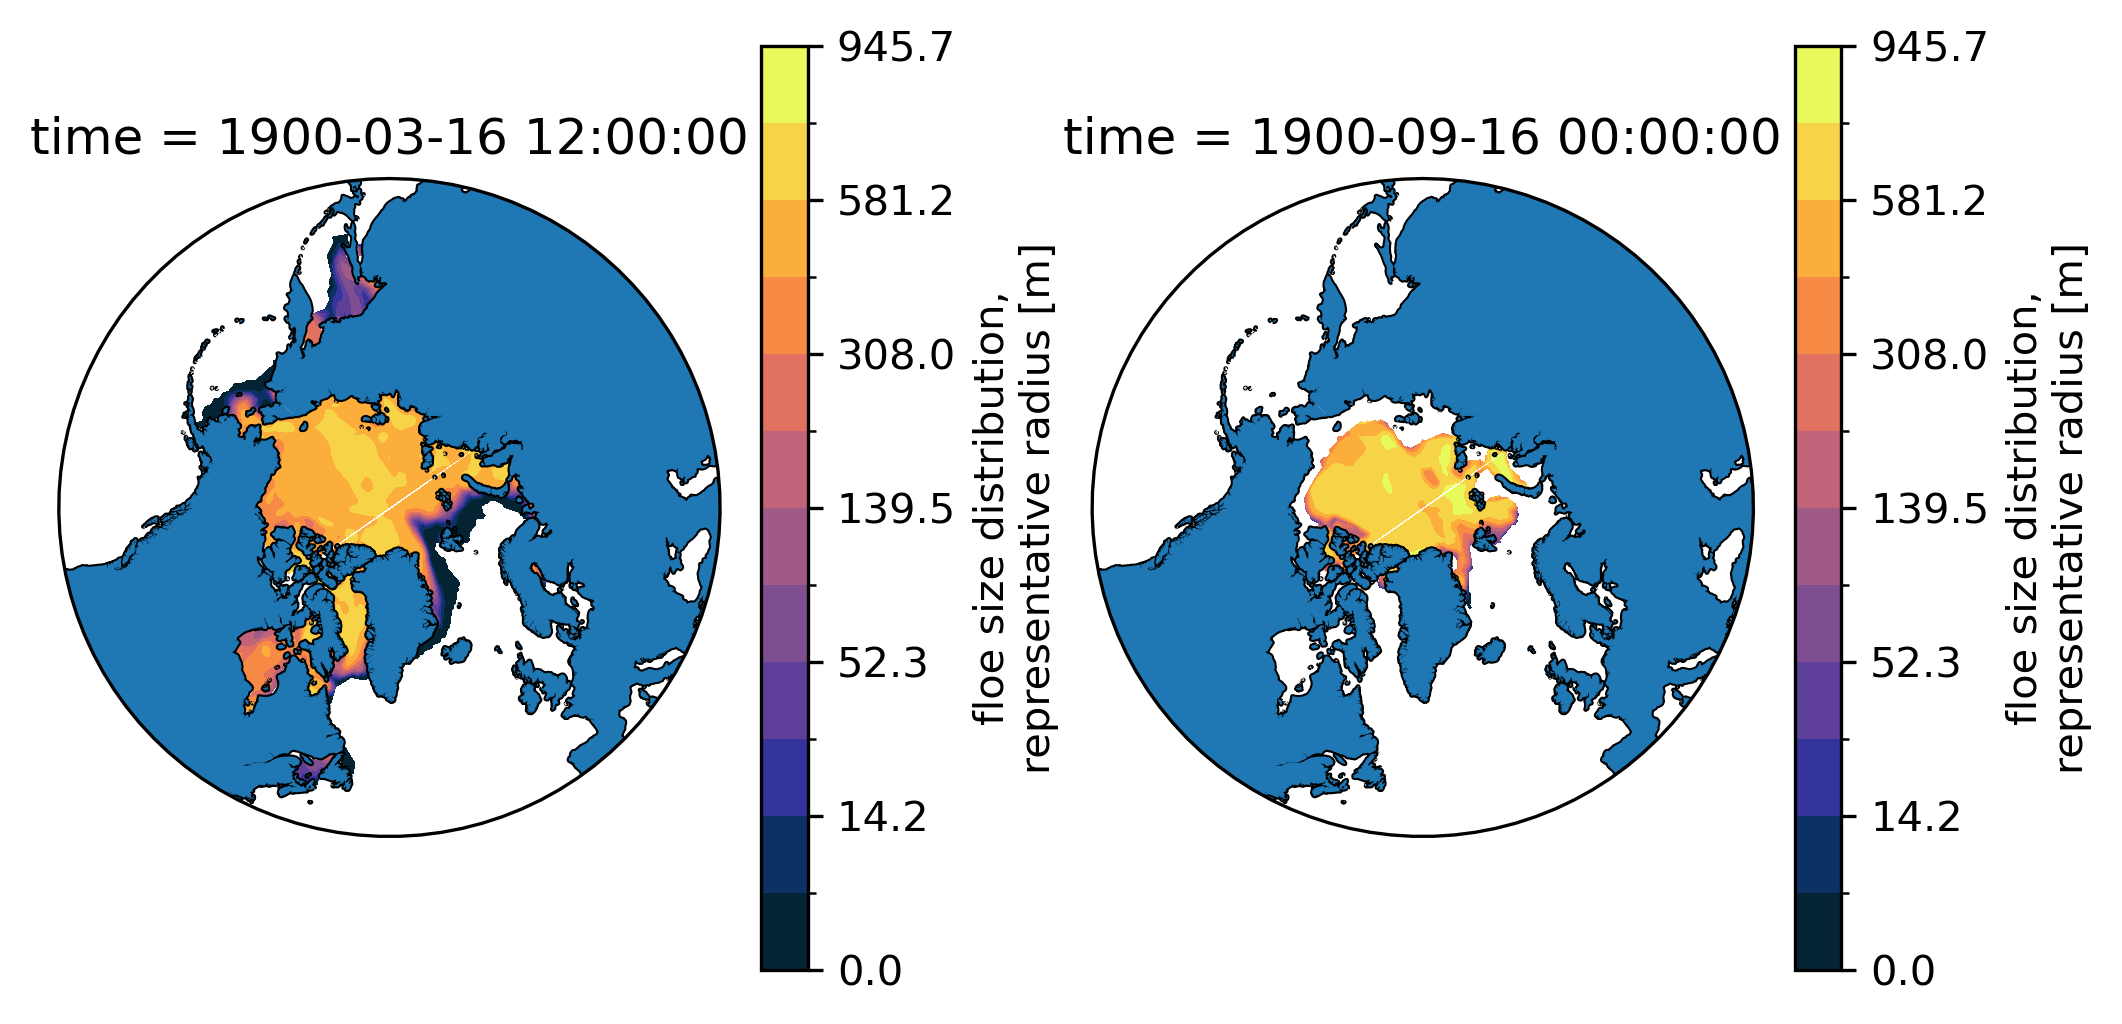

In [20]:
levels = np.concatenate([BinLeft, [BinRight[-1]]])
hemisphere = "north"

fig, axes = map_figure(hemisphere)

ds_plot = ds.where(ds['aice_m']>0.15)
ds_plot['fsdrad_m'].isel(time=2).plot.contourf(
        ax=axes[0],
        x="lon",
        y="lat",
        levels=levels,  
        cmap=cmo.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=True
    )

ds_plot['fsdrad_m'].isel(time=8).plot.contourf(
        ax=axes[1],
        x="lon",
        y="lat",
        levels=levels,  
        cmap=cmo.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=True
    )

### Tendencies for each hemisphere

In [174]:
# Area-weighted average function
def area_weighted_mean(var_in, area_in, mask_in):
    masked_var = var_in.where(mask_in)
    masked_area = area_in.where(mask_in)
    return (masked_var * masked_area).sum(dim=['ni','nj']) / masked_area.sum(dim=['ni','nj'])

# Apply to your variables
mask_north = (ds['aice_m']>0.15) & (ds['TLAT'] > 0)
afsd_north = area_weighted_mean(var_in=ds['afsd_m'], area_in=ds['tarea'], mask_in=mask_north)

dafsd_latm_north = area_weighted_mean(var_in=ds['dafsd_latm_m'], area_in=ds['tarea'], mask_in=mask_north)
dafsd_latg_north = area_weighted_mean(var_in=ds['dafsd_latg_m'], area_in=ds['tarea'], mask_in=mask_north)
dafsd_newi_north = area_weighted_mean(var_in=ds['dafsd_newi_m'], area_in=ds['tarea'], mask_in=mask_north)
dafsd_weld_north = area_weighted_mean(var_in=ds['dafsd_weld_m'], area_in=ds['tarea'], mask_in=mask_north)
dafsd_wave_north = area_weighted_mean(var_in=ds['dafsd_wave_m'], area_in=ds['tarea'], mask_in=mask_north)

mask_south = (ds['aice_m']>0.15) & (ds['TLAT'] < 0)
afsd_south = area_weighted_mean(var_in=ds['afsd_m'], area_in=ds['tarea'], mask_in=mask_south)

dafsd_latm_south = area_weighted_mean(var_in=ds['dafsd_latm_m'], area_in=ds['tarea'], mask_in=mask_south)
dafsd_latg_south = area_weighted_mean(var_in=ds['dafsd_latg_m'], area_in=ds['tarea'], mask_in=mask_south)
dafsd_newi_south = area_weighted_mean(var_in=ds['dafsd_newi_m'], area_in=ds['tarea'], mask_in=mask_south)
dafsd_weld_south = area_weighted_mean(var_in=ds['dafsd_weld_m'], area_in=ds['tarea'], mask_in=mask_south)
dafsd_wave_south = area_weighted_mean(var_in=ds['dafsd_wave_m'], area_in=ds['tarea'], mask_in=mask_south)

Text(0.5, 0, 'Floe radius [m]')

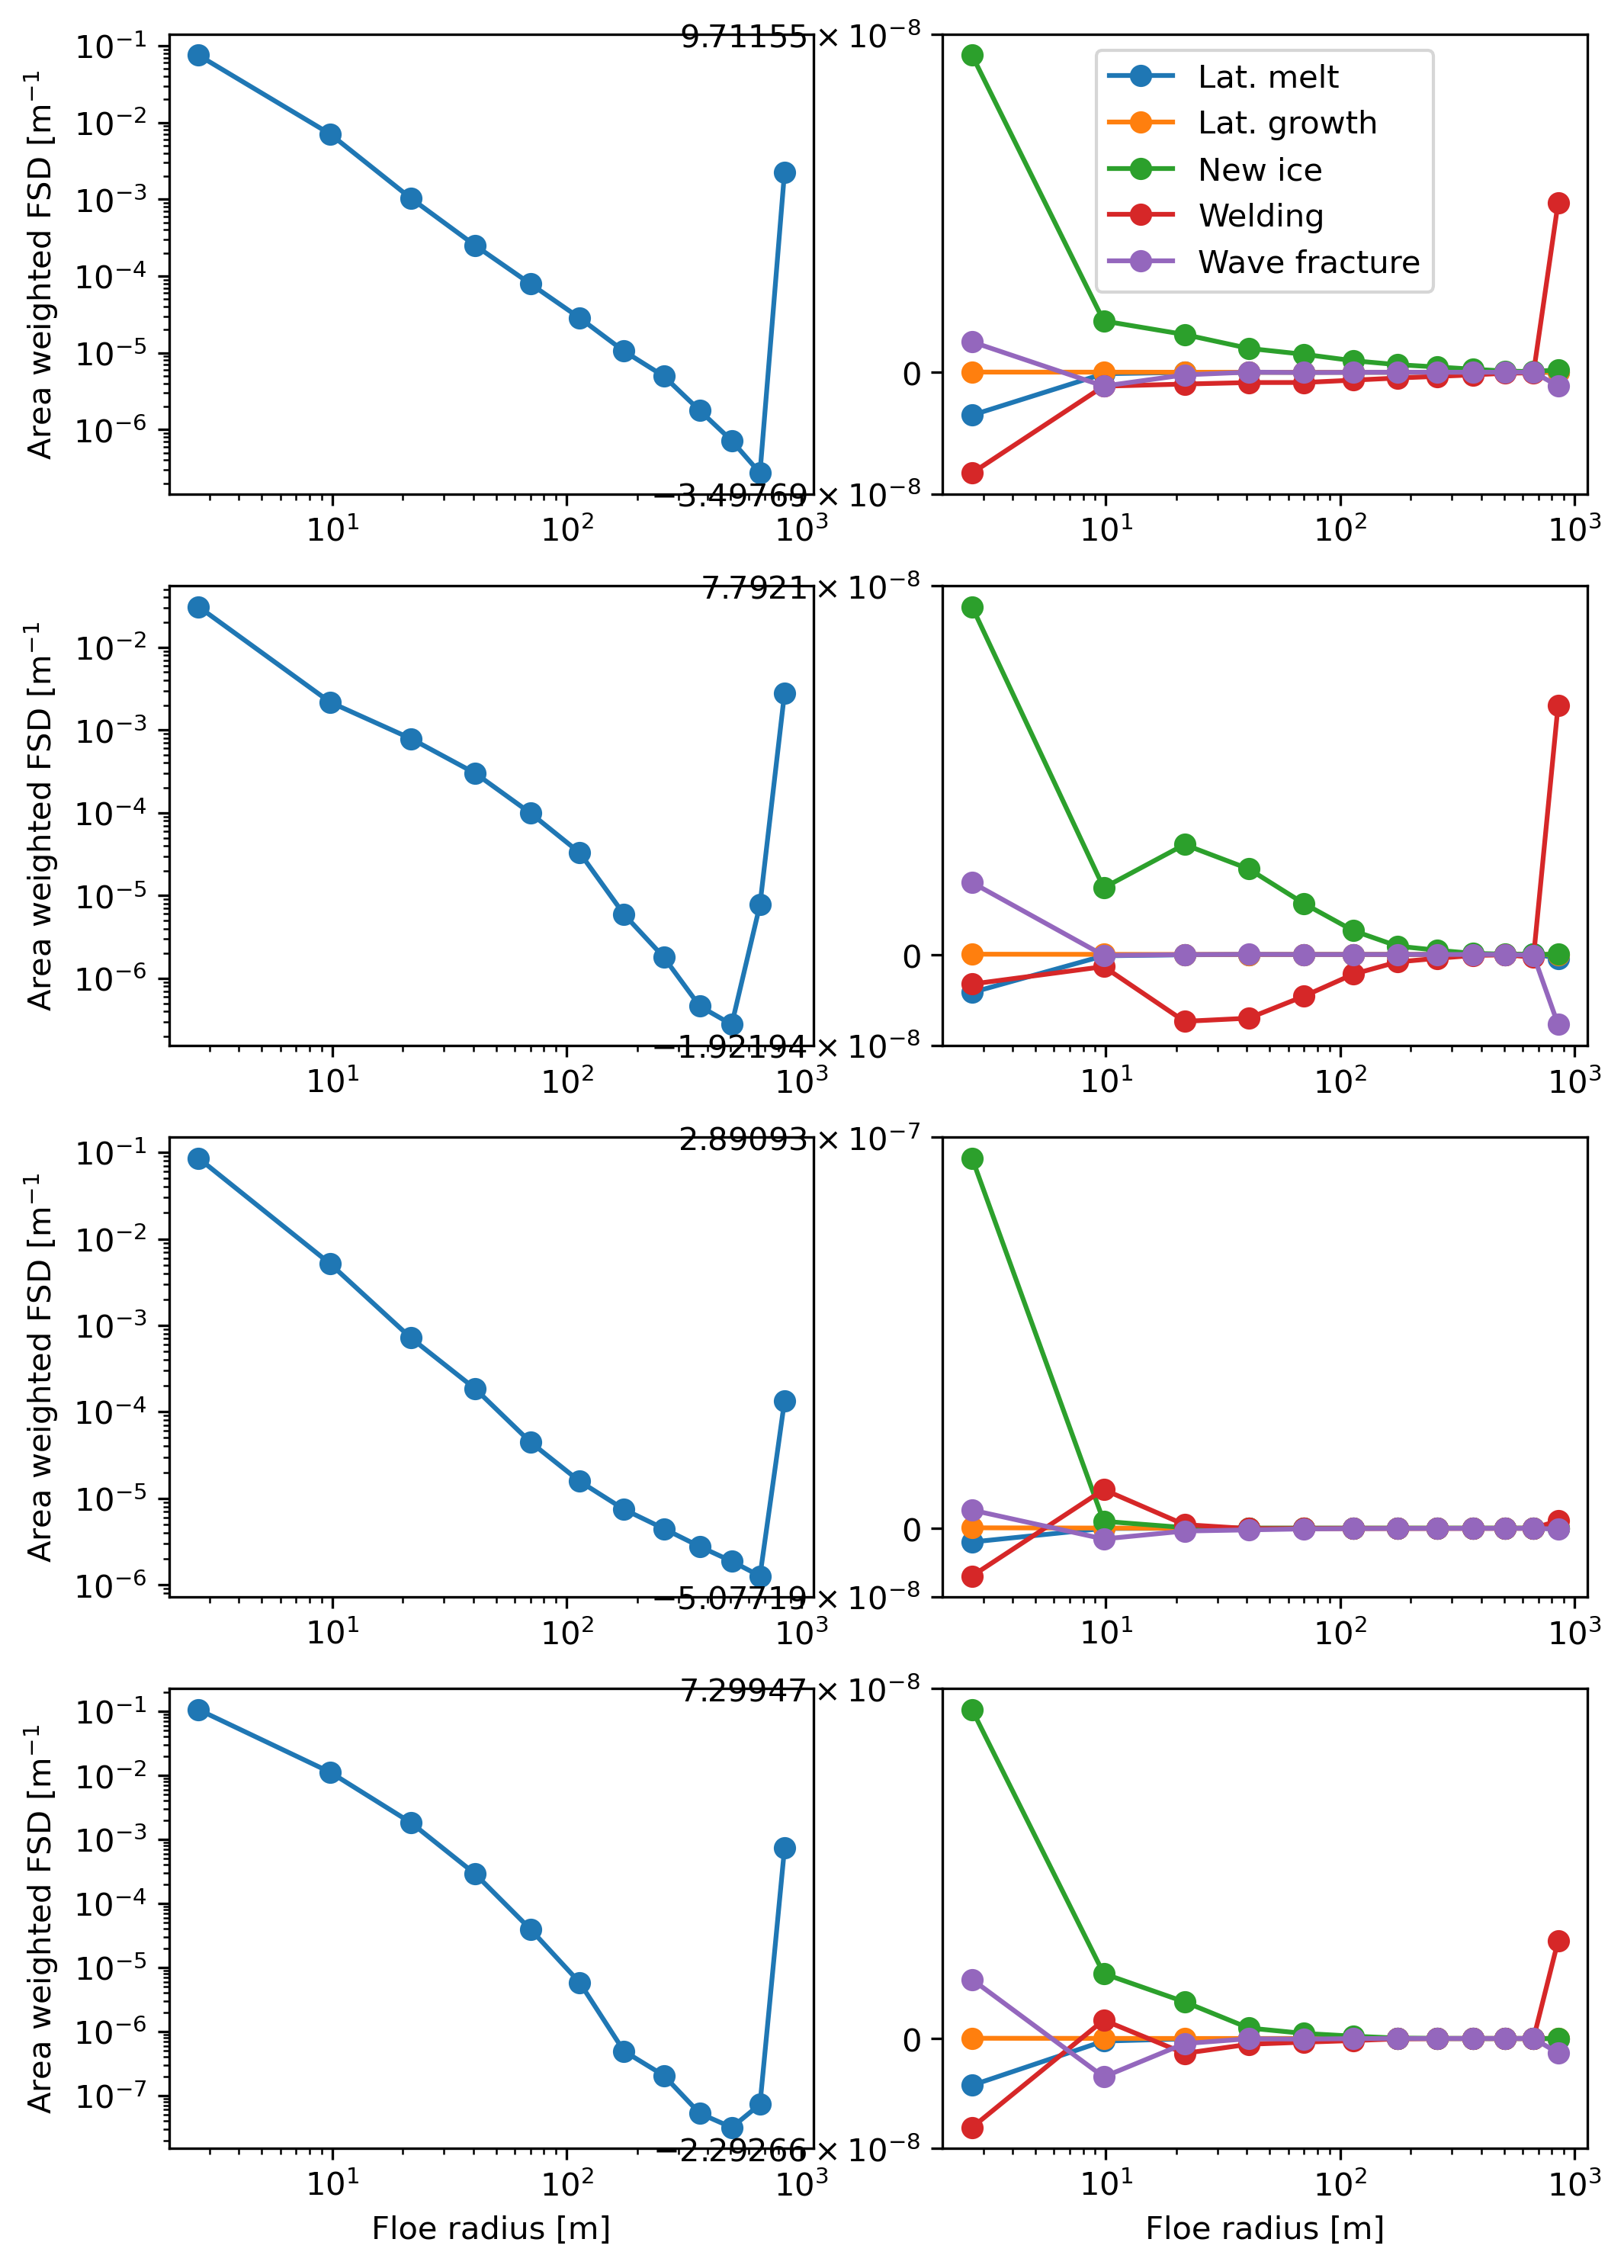

In [193]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=4,
    figsize=(8, 12),
)

# -----------------------------
# Data groups
# -----------------------------
north_vars = [
    dafsd_latm_north,
    dafsd_latg_north,
    dafsd_newi_north,
    dafsd_weld_north,
    dafsd_wave_north,
]

# MAKE THIS A DICT?
dafsd_labels = [
    "Lat. melt",
    "Lat. growth",
    "New ice",
    "Welding",
    "Wave fracture",
]

south_vars = [
    dafsd_latm_south,
    dafsd_latg_south,
    dafsd_newi_south,
    dafsd_weld_south,
    dafsd_wave_south,
]

times = [2, 8]


# -----------------------------
# Left column: AFSD log–log
# -----------------------------
afsd_groups = [afsd_north, afsd_north, afsd_south, afsd_south]

for i, (t, afsd) in enumerate(zip(times * 2, afsd_groups)):
    axes[i, 0].plot(NFSD, afsd.isel(time=t), marker='o')


# -----------------------------
# Right column: ΔAFSD log–symlog
# -----------------------------
dafsd_groups = [north_vars, north_vars, south_vars, south_vars]

for i, (t, group) in enumerate(zip(times * 2, dafsd_groups)):
    for j, var in enumerate(group):
        axes[i, 1].plot(NFSD, var.isel(time=t), marker='o', label=dafsd_labels[j])


# -----------------------------
# Axis scaling
# -----------------------------
for ax in axes[:, 0]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel('Area weighted FSD [m$^{-1}$')

for ax in axes[:, 1]:
    ax.set_xscale("log")
    ax.set_yscale("symlog", linthresh=1e-3)

axes[0, 1].legend()


axes[3, 0].set_xlabel('Floe radius [m]')
axes[3, 1].set_xlabel('Floe radius [m]')

# plt.tight_layout()

In [184]:
dafsd_latm_south.max().values

array(1.4505705e-10)

### Timeseries of the tendencies

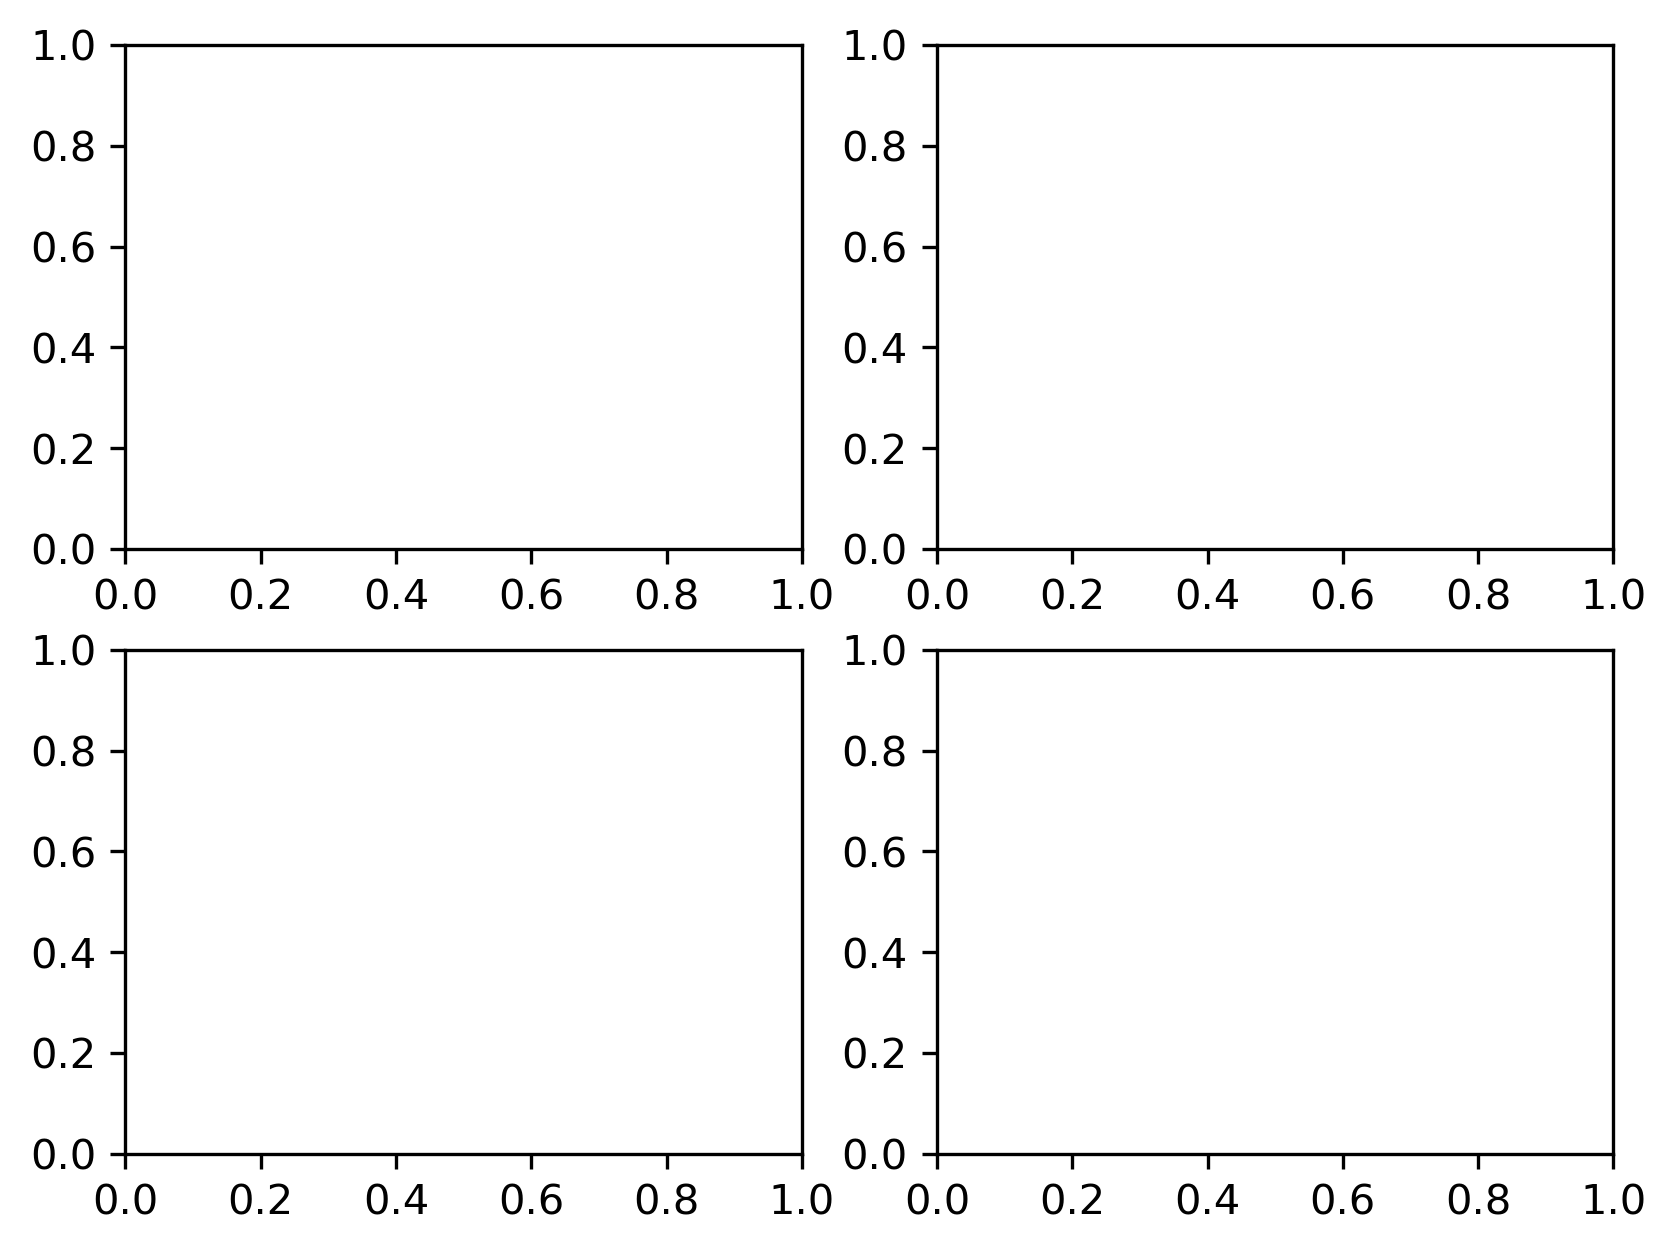

In [ ]:
def get_representative_floe_size(NFSD_in, afsd_in, aice_in):
    floe_binwidth = NFSD_in.copy()
    floe_binwidth.values, _, _, _, _, _ = ciceBinWidths(NFSD_in)
    afsd_in = afsd_in * floe_binwidth
    Nf = len(NFSD_in)
    rep_floe_size = (afsd_in*NFSD /aice_in).sum(dim='nf') 
    return rep_floe_size

### Which ocean variables are available at monthly frequency?

In [5]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [6]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
KE,Layer kinetic energy per unit mass,,area:mean z_l:mean yh:mean xh:mean time: mean,m2 s-2
SSH_max,Sea Surface Height,,area:mean yh:mean xh:mean time: max,m
SSH_min,Sea Surface Height,,area:mean yh:mean xh:mean time: min,m
agessc,Ideal Age Tracer,ideal_age_tracer,area:mean z_l:mean yh:mean xh:mean time: mean,yr
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
e,Interface Height Relative to Mean Sea Level,,area:mean rho2_i:point yh:mean xh:mean time: mean,m
hfds,Surface ocean heat flux from SW+LW+latent+sens...,surface_downward_heat_flux_in_sea_water,area:mean yh:mean xh:mean time: mean,W m-2


### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [7]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

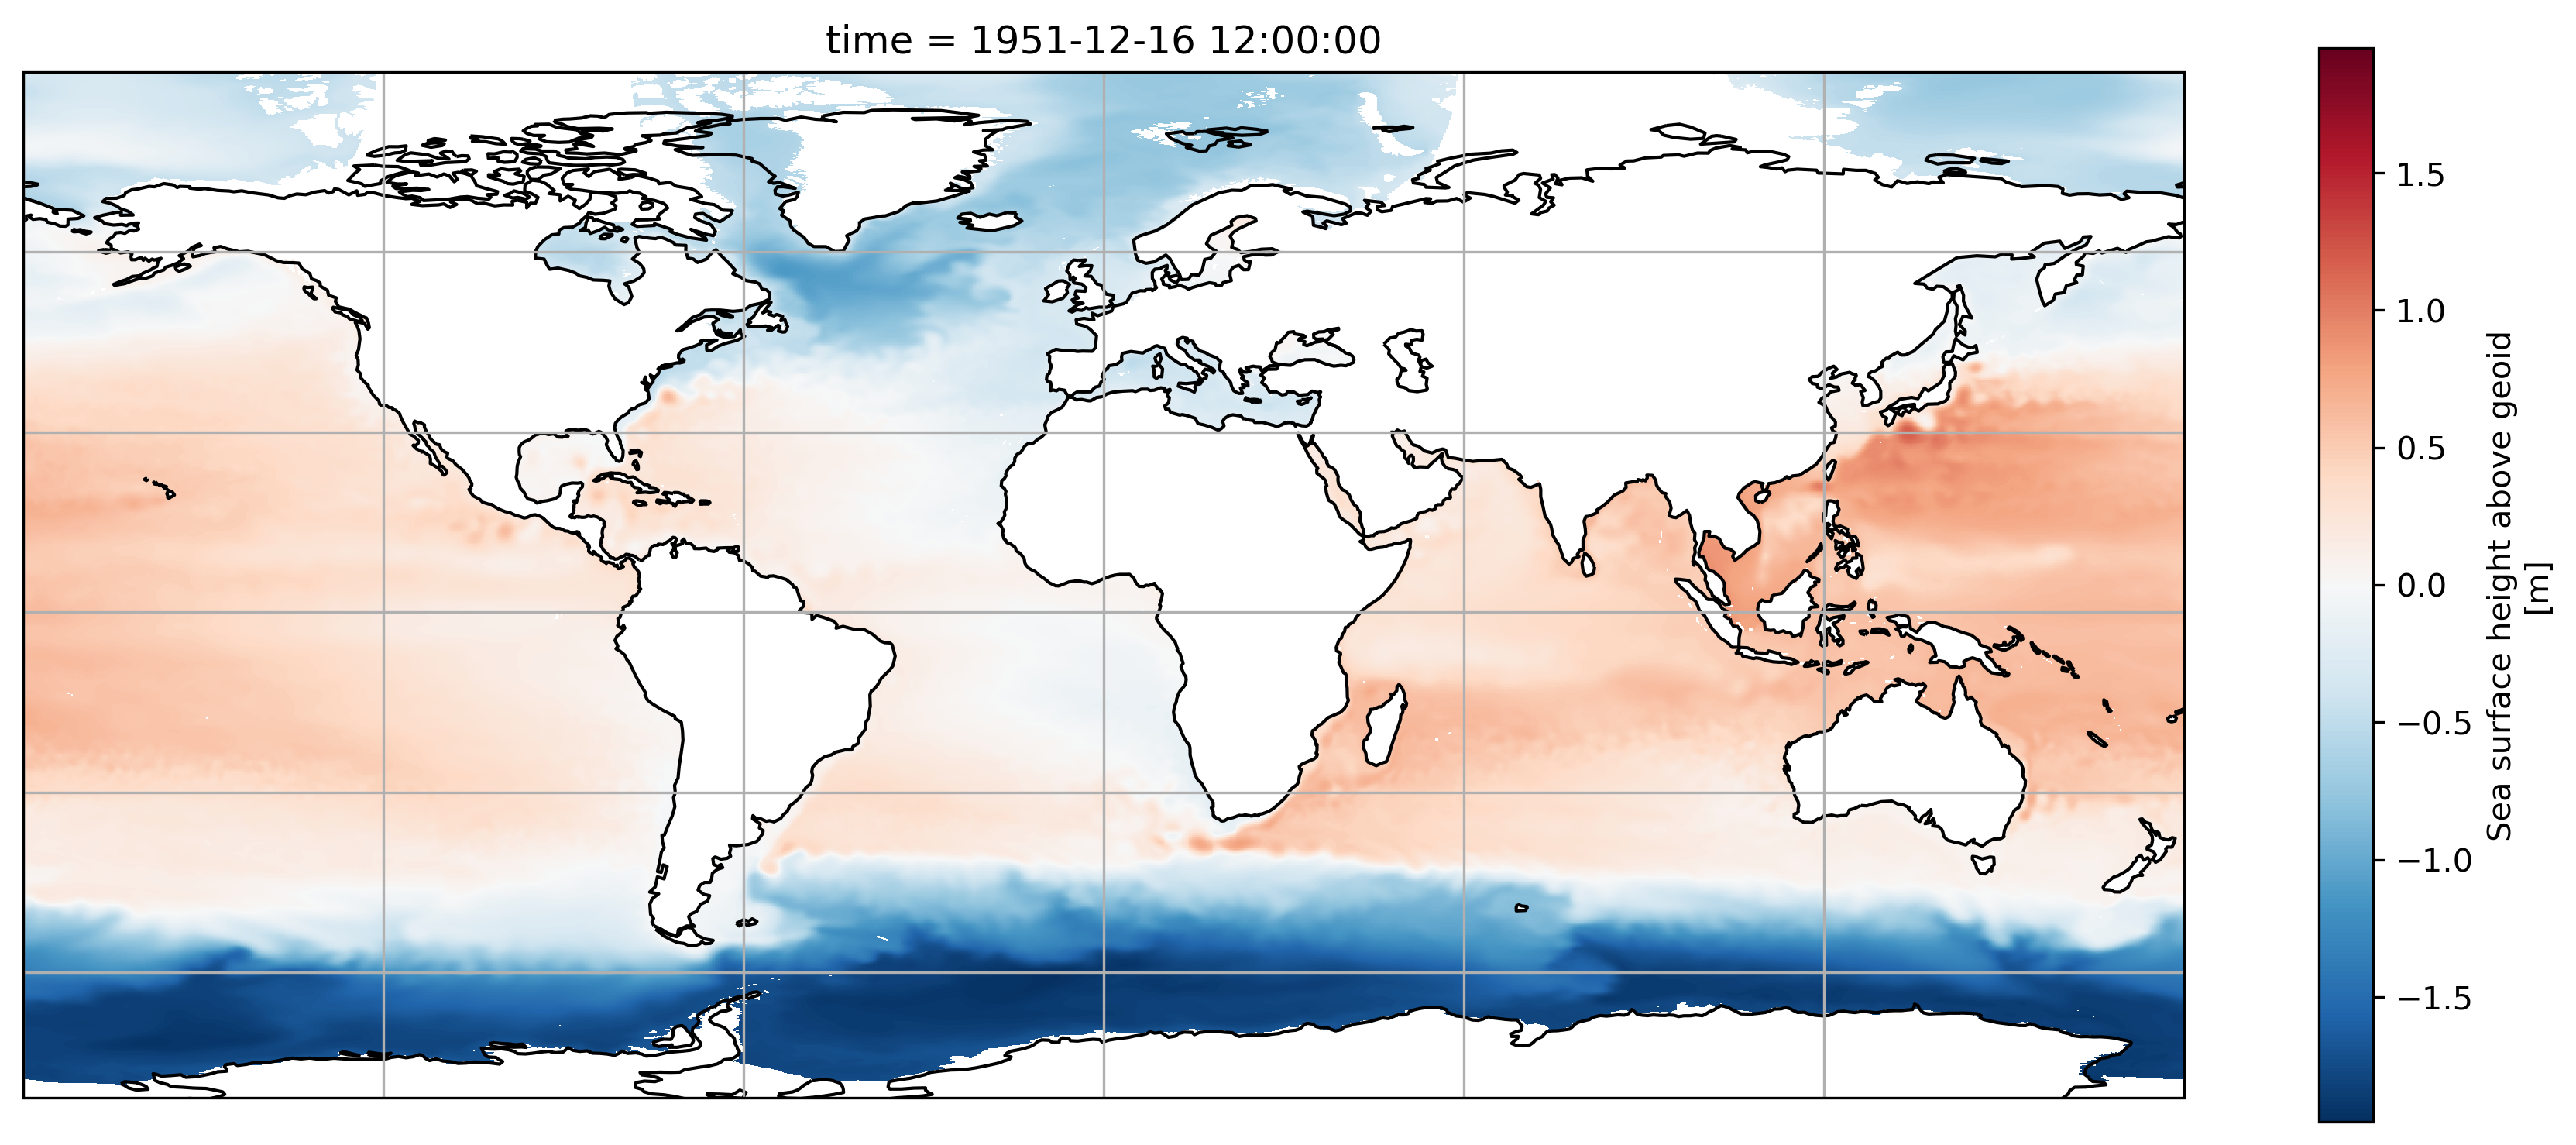

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [9]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()